In [1]:
import pandas as pd
import re
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
cell_line = 'U87MG_CENTRAL_NERVOUS_SYSTEM'
#U251MG_CENTRAL_NERVOUS_SYSTEM, U87MG_CENTRAL_NERVOUS_SYSTEM, A549_LUNG, CAL27_UPPER_AERODIGESTIVE_TRACT, MIAPACA2_PANCREAS

df_expresion = pd.read_csv("/home/estrella/TFM/Datos/depmap/M19Q2_metabol_modelo.csv", sep = '\t')
df_expresion = df_expresion.set_index('cell_line')
df_expresion_t = df_expresion.T
expr_genes_linea = df_expresion_t[cell_line]

df_ceres = pd.read_csv("/home/estrella/TFM/Datos/depmap/M19Q2_ceres_metabol_python.csv", sep = '\t')
df_ceres = df_ceres.set_index('cell_line')
df_ceres_t = df_ceres.T
ceres_genes_linea = df_ceres_t[cell_line]


In [5]:
#CALCULO LAS FRECUENCIAS PARA EL DATAFRAME DE LOS LOCALES
df_frecuencia_esenciales_locales = pd.read_csv('./thresholding/con_th_locales/' + cell_line + '/df_frecuencia_esenciales.csv', sep = ',')
df_frecuencia_esenciales_locales.rename(columns={'Unnamed: 0':'Genes'},inplace=True)
df_frecuencia_esenciales_locales.columns = ['Genes','P05_P90_LocalMEAN', 'P05_P80_LocalMEAN', 'P05_P70_LocalMEAN', 
                                            'P05_P65_LocalMEAN', 'P10_P90_LocalMEAN','P10_P80_LocalMEAN',
                                            'P10_P70_LocalMEAN', 'P10_P65_LocalMEAN', 'P15_P90_LocalMEAN',
                                            'P15_P80_LocalMEAN', 'P15_P70_LocalMEAN','P15_P65_LocalMEAN', 'Frecuencia']
df_frecuencia_esenciales_locales = df_frecuencia_esenciales_locales.set_index('Genes')
df_frecuencia_esenciales_locales = df_frecuencia_esenciales_locales.drop(['Frecuencia'], axis=1)

In [6]:
#CALCULO LAS FRECUENCIAS PARA EL DATAFRAME DE LOS GLOBALES
df_frecuencia_esenciales = pd.read_csv('./thresholding/Th_upper_y_lower/' + cell_line + '/df_frecuencia_esenciales.csv', sep = ',')
df_frecuencia_esenciales = df_frecuencia_esenciales.set_index('Genes')
df_frecuencia_esenciales = df_frecuencia_esenciales.drop(['Frecuencia'], axis=1)

In [7]:
#UNO LOS DOS DATAFRAMES
df_frecuencia_esenciales = pd.concat([df_frecuencia_esenciales, df_frecuencia_esenciales_locales], axis=1)

#Calculo las frecuencias en las que aprece cada gen esencial en los diferentes modelos.
col_list= list(df_frecuencia_esenciales)
df_frecuencia_esenciales['Frecuencia'] = df_frecuencia_esenciales[col_list].sum(axis=1)/(len(col_list))

#Selecciono los genes con frecuencia diferente a cero.
df_genes_esenciales = df_frecuencia_esenciales.loc[df_frecuencia_esenciales['Frecuencia'] != 0]


In [ ]:
#REPRESENTACION DE CADA GEN VS SU FRECUENCIA DE PREDICCION COMO ESENCIAL POR LOS MODELOS

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

sns.despine()
y = df_genes_esenciales.sort_values('Frecuencia')

barplot = sns.barplot(x=y.index, y=y['Frecuencia'], color = 'cadetblue' , ax=ax1).set_title(cell_line, size= 40, loc='center', fontweight="bold")
plt.setp(ax1.get_xticklabels(), size =22, rotation=90)
plt.setp(ax1.get_yticklabels(), size =30)

#Parametros del subplot
ax1.set_xlabel('Genes', size = 44)
ax1.set_ylabel('Frecuency', size = 44)

fig.set_size_inches(44, 22) #anchura, altura
fig_ruta = './thresholding/genes/' + cell_line + '/grafico_esencialesVSfrecuencia.png'
fig.savefig(fig_ruta, bbox_inches='tight',dpi=80)

In [8]:
#DATA FRAME CON LAS FRECUENCIAS, CERES Y EXPRESION
columnas = ['Frecuencia', 'CERES', 'Expr']
df_freq_ceres_exp = pd.DataFrame(index=df_genes_esenciales.index, columns=columnas)

for genes in df_genes_esenciales.index:
    if genes in ceres_genes_linea.index:
        df_freq_ceres_exp.at[genes, 'CERES'] = ceres_genes_linea.at[genes]
    else:
        df_freq_ceres_exp.at[genes, 'CERES'] = float('nan')
        
    if genes in expr_genes_linea.index:
        df_freq_ceres_exp.at[genes, 'Expr'] = expr_genes_linea.at[genes]
    else:
        df_freq_ceres_exp.at[genes, 'Expr'] = float('nan')
        
    if genes in df_genes_esenciales.index:
        df_freq_ceres_exp.at[genes, 'Frecuencia'] = df_genes_esenciales.at[genes, 'Frecuencia'].round(2)
    else:
        df_freq_ceres_exp.at[genes, 'Frecuencia'] = float('nan')
 

In [140]:
# DATA FRAME PARA PLOTEAR DESPÚES LOS BOXPLOT AGRUPADOS POR MODELOS  
lista_modelos = ['P05_P90', 'P05_P80', 'P05_P70', 'P05_P65', 'P10_P90', 'P10_P80', 'P10_P70', 'P10_P65', 'P15_P90',
                 'P15_P80', 'P15_P70', 'P15_P65', 'P05_P90_LocalMEAN', 'P05_P80_LocalMEAN', 'P05_P70_LocalMEAN', 
                'P05_P65_LocalMEAN', 'P10_P90_LocalMEAN','P10_P80_LocalMEAN','P10_P70_LocalMEAN', 'P10_P65_LocalMEAN', 
                 'P15_P90_LocalMEAN','P15_P80_LocalMEAN', 'P15_P70_LocalMEAN','P15_P65_LocalMEAN']

lista_modelo_id = []
lista_modelo_simple = []
lista_cell_line = []
lista_genes_id = []
score_CERES = []
expr = []
lista_frecuencia = []

for modelo in lista_modelos:
    for gene in df_genes_esenciales.index.tolist(): 
        lista_genes_id.append (gene)
        lista_modelo_id.append (cell_line + '_' + modelo)
        lista_modelo_simple.append (modelo)
        lista_cell_line.append (cell_line)
        lista_frecuencia.append (df_genes_esenciales.loc[gene,modelo])
        if gene in ceres_genes_linea:
            score_CERES.append (ceres_genes_linea.at[gene])
        else:
            score_CERES.append ('')
        if gene in expr_genes_linea:
            expr.append (expr_genes_linea.at[gene])
        else:
            expr.append ('')
            
dicc_data = {'cell_line' : lista_cell_line, 'modelo_id' : lista_modelo_id, 'gen_id' : lista_genes_id, 'score_CERES' : score_CERES, 'Expr' : expr, 'Esencial' : lista_frecuencia, 'Modelo_simple' : lista_modelo_simple}
df_allModels_essetial_ceres = pd.DataFrame (dicc_data)


In [17]:
df_freq_ceres_exp.loc["DTYMK"]

Frecuencia        0.38
CERES        -0.801073
Expr           6.88081
Name: DTYMK, dtype: object

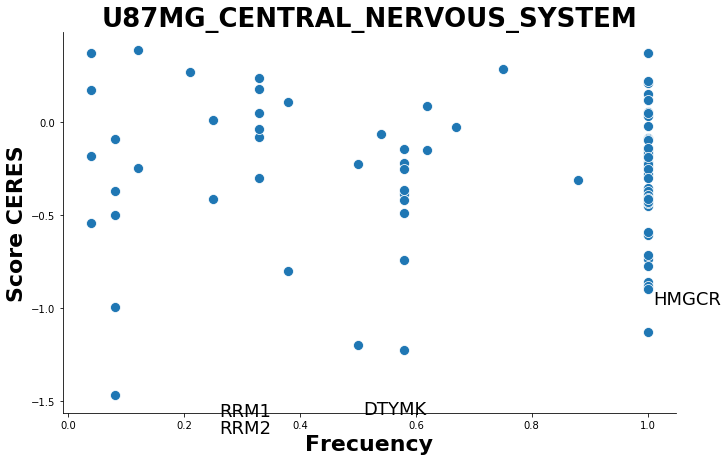

In [9]:
# REPRESENTACION DE CADA GEN (pronosticado como esencial) FRECUENCIA VS ESENCIABILIDAD

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

sns.set(font_scale=2.5) #Cambia el tamaño del la fuente de los ejes
sns.set_style(style='ticks', rc=None) #Para e fondo del gráfico
sns.despine()

p1 = sns.scatterplot(x=df_freq_ceres_exp['Frecuencia'], y=df_freq_ceres_exp['CERES'], ax = ax1, s=100).set_title(cell_line, size= 26, loc='center', fontweight="bold")
#Parametros del subplot
ax1.set_xlabel('Frecuency', size = 22, weight='bold')
ax1.set_ylabel('Score CERES', size = 22, weight='bold')

#Calculas las coordenadas de los puntos a poner texto.
ax1.text(0.26,-1.58,'RRM1', color = 'black', fontsize=18)
ax1.text(0.26,-1.67,'RRM2', color = 'black', fontsize=18)
ax1.text(1.01,-0.98,'HMGCR', color = 'black', fontsize=18)
ax1.text(0.51,-1.57,'DTYMK', color = 'black', fontsize=18)

fig.set_size_inches(11, 7) #anchura, altura
fig_ruta = './thresholding/genes/' + cell_line + '/grafico_ceresVSfrecuencia.png'
#fig.savefig(fig_ruta, bbox_inches='tight', dpi = 80)


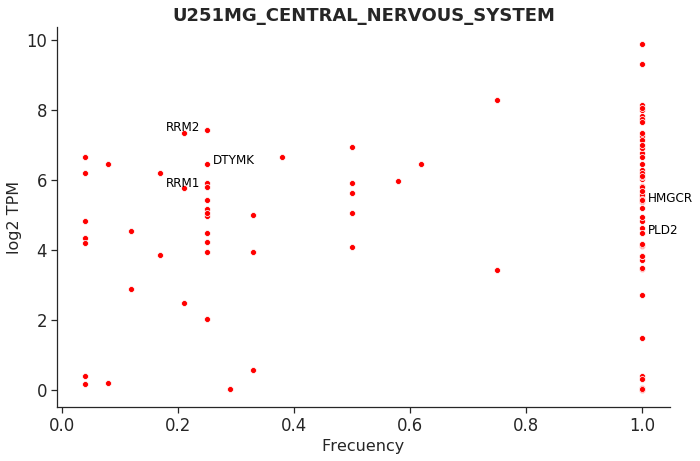

In [307]:
# REPRESENTACION DE CADA GEN (pronosticado como esencial) FRECUENCIA VS EXPRESION

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

sns.set(font_scale=1.5) #Cambia el tamaño del la fuente de los ejes
sns.set_style(style='ticks', rc=None) #Para e fondo del gráfico
sns.despine()
sns.scatterplot(x=df_freq_ceres_exp['Frecuencia'], y=df_freq_ceres_exp['Expr'], color = 'red', ax = ax1).set_title(cell_line, size= 18, loc='center', fontweight="bold")

#Puntos a etiquetar
df_freq_ceres_exp[(df_freq_ceres_exp['Frecuencia'] < 0.2) & (df_freq_ceres_exp['Expr'] < 2) ]
ax1.text(1.01, 4.48,'PLD2', color = 'black', fontsize=12) 
ax1.text(0.18,5.82,'RRM1', color = 'black', fontsize=12)
ax1.text(0.18,7.40,'RRM2', color = 'black', fontsize=12)
ax1.text(1.01,5.37,'HMGCR', color = 'black', fontsize=12)
ax1.text(0.26,6.46,'DTYMK', color = 'black', fontsize=12)

#Parametros del subplot
ax1.set_xlabel('Frecuency', size = 16)
ax1.set_ylabel('log2 TPM', size = 16)

fig.set_size_inches(11, 7) #anchura, altura
fig_ruta = './thresholding/genes/' + cell_line + '/grafico_exprVSfrecuencia_scatter.png'
fig.savefig(fig_ruta, bbox_inches='tight', dpi = 80)

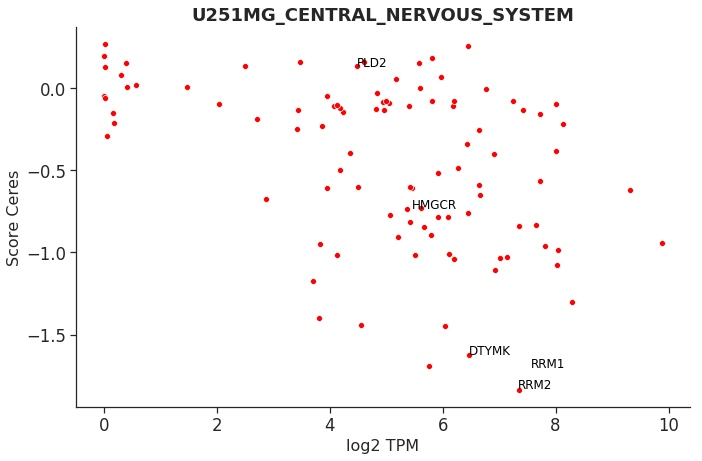

In [322]:
# REPRESENTACION DE CADA GEN (pronosticado como esencial) ESENCIABILIDAD VS EXPRESION

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

sns.set(font_scale=1.5) #Cambia el tamaño del la fuente de los ejes
sns.set_style(style='ticks', rc=None) #Para e fondo del gráfico
sns.despine()
sns.scatterplot(y=df_freq_ceres_exp['CERES'], x=df_freq_ceres_exp['Expr'], color = 'red', ax = ax1).set_title(cell_line, size= 18, loc='center', fontweight="bold")

#Parametros del subplot
ax1.set_xlabel('log2 TPM', size = 16)
ax1.set_ylabel('Score Ceres', size = 16)

#Puntos a etiquetar
ax1.text(4.48, 0.13,'PLD2', color = 'black', fontsize=12) 
ax1.text(7.56,-1.70,'RRM1', color = 'black', fontsize=12)
ax1.text(7.34,-1.83,'RRM2', color = 'black', fontsize=12)
ax1.text(5.46,-0.73,'HMGCR', color = 'black', fontsize=12)
ax1.text(6.46,-1.62,'DTYMK', color = 'black', fontsize=12)

fig.set_size_inches(11, 7) #anchura, altura
fig_ruta = './thresholding/genes/' + cell_line + '/grafico_exprVSCeres2.png'
fig.savefig(fig_ruta, bbox_inches='tight', dpi =80)


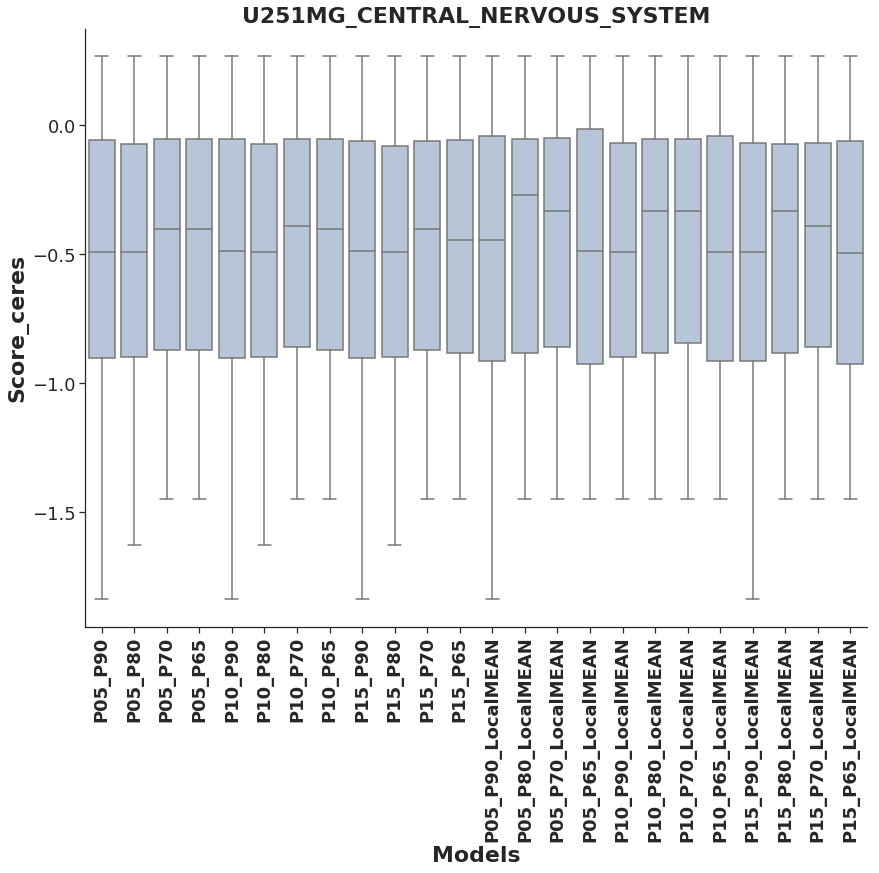

In [323]:
# BOXPLOTS DE LA DISTRIBUCION DE CERES DE CADA MODELO
def_df_allModels_essetial_ceres = df_allModels_essetial_ceres.loc[df_allModels_essetial_ceres['Esencial'] == 1]

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

sns.despine()
bx = sns.boxplot(x='Modelo_simple', y='score_CERES', data=def_df_allModels_essetial_ceres, color ="lightsteelblue", ax = ax1).set_title(cell_line, size= 22, loc='center', fontweight="bold")
plt.setp(ax1.get_xticklabels(), size = 18, rotation=90, fontweight='bold')
plt.setp(ax1.get_yticklabels(), size =18)
    
#Parametros del subplot
ax1.set_xlabel('Models', size = 22, fontweight='bold')
ax1.set_ylabel('Score_ceres', size = 22, fontweight='bold')

fig.set_size_inches(14, 11) #anchura, altura
fig_ruta = './thresholding/genes/' + cell_line + '/grafico_modelosVsCeresScore2.png'
fig.savefig(fig_ruta, bbox_inches='tight', dpi = 80)

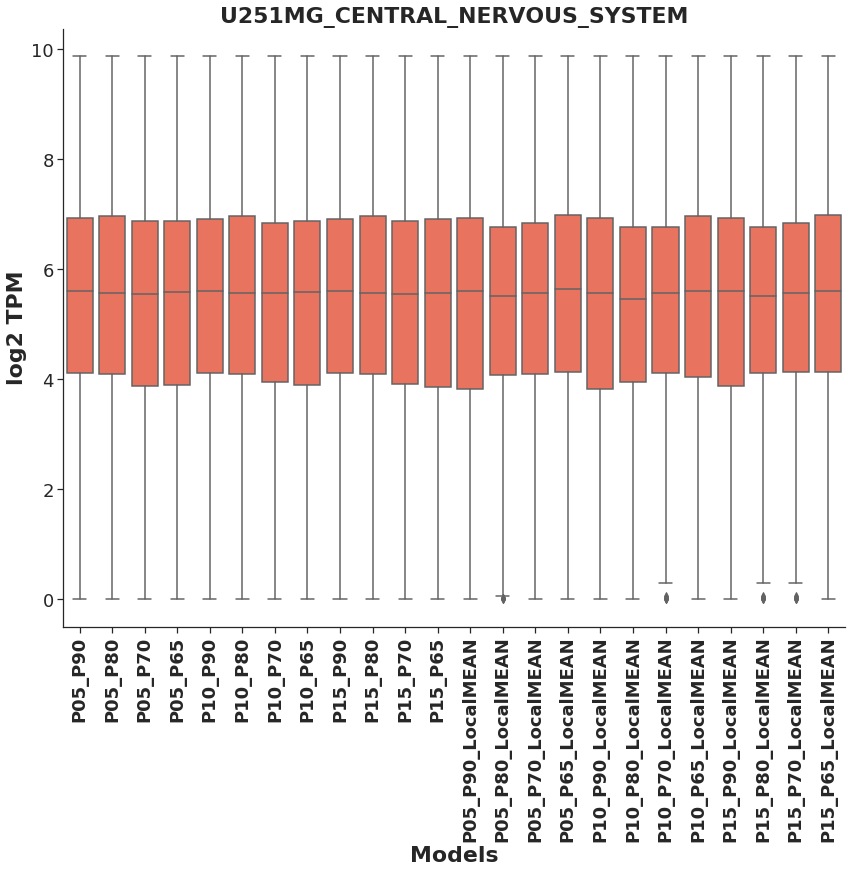

In [324]:
# BOXPLOTS DE LA DISTRIBUCION DE EXPRESION DE CADA MODELO
df_allModels_essetial_ceres['Expr'].replace('', np.nan, inplace=True) #Genes sin valor de expr estan en blanco, y los paso a NaN
df_allModels_essetial_ceres
df_allModels_essetial_ceres.dropna(subset=['Expr'], inplace=True) #Quito los NaN 
def_df_allModels_essetial_ceres = df_allModels_essetial_ceres.loc[df_allModels_essetial_ceres['Esencial'] == 1] #Me quedo son los genes que han sido predichos como esenciales para cada uno de los modelos

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
sns.despine()
bx = sns.boxplot(x='Modelo_simple', y='Expr', data=def_df_allModels_essetial_ceres, color ="tomato", ax = ax1).set_title(cell_line, size= 22, loc='center', fontweight="bold")
plt.setp(ax1.get_xticklabels(), size = 18, rotation=90, fontweight='bold')
plt.setp(ax1.get_yticklabels(), size =18)

#Parametros del subplot
ax1.set_xlabel('Models', size = 22, fontweight='bold')
ax1.set_ylabel('log2 TPM', size = 22, fontweight='bold')

fig.set_size_inches(14, 11) #anchura, altura
fig_ruta = './thresholding/genes/' + cell_line + '/grafico_modelosVsExpr2.png'
fig.savefig(fig_ruta, bbox_inches='tight', dpi = 80)